<a href="https://colab.research.google.com/github/adimyth/interesting_stuff/blob/master/text/spanish_english_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Level Seq2Seq Model

Shamelessly, copied from [here](https://github.com/hlamba28/Word-Level-Eng-Mar-NMT/blob/master/WordLevelEngMarNMT.ipynb)

## Encoder
![Encoder](https://guillaumegenthial.github.io/assets/img2latex/seq2seq_vanilla_encoder.svg)

## Decoder
![Decoder](https://guillaumegenthial.github.io/assets/img2latex/seq2seq_vanilla_decoder.svg)


Stepwise, the decoder operates as - 
![Decoder Operation](https://i.imgur.com/sWRGsi4.png)

## Dataset
English to Spanish Conversion - http://www.manythings.org/anki/spa-eng.zip

In [1]:
!wget http://www.manythings.org/anki/spa-eng.zip

--2020-04-19 09:09:10--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:3037::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4781548 (4.6M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   4.56M  12.2MB/s    in 0.4s    

2020-04-19 09:09:10 (12.2 MB/s) - ‘spa-eng.zip’ saved [4781548/4781548]



In [2]:
!unzip -l spa-eng.zip
!unzip spa-eng.zip

Archive:  spa-eng.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
     1441  2020-03-15 02:17   _about.txt
 18493172  2020-03-15 02:17   spa.txt
---------                     -------
 18494613                     2 files
Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [1]:
import matplotlib.pyplot as plt
from itertools import islice
import math
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import string
from string import digits
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution
disable_eager_execution()

Disabling eager execution because all zeros mask raises some CuDNN kernel level issue. Refere [here](https://github.com/tensorflow/tensorflow/issues/33148)

In [0]:
%matplotlib inline
sns.set_style("whitegrid")

In [0]:
lines = pd.read_table('spa.txt', names=['english', 'spanish', 'attributes'])
# lines = pd.DataFrame({"english": ["Juan eats apples"], "spanish": ["Juan come manzanas"], "attributes": ""})

In [5]:
lines.shape

(123770, 3)

In [0]:
lines = lines.drop(columns=['attributes'])

In [0]:
for col in lines.columns:
    # lowercase
    lines[col] = lines[col].apply(lambda x: x.lower())
    # remove quotes
    lines[col] = lines[col].apply(lambda x: re.sub("'", "", x))
    # remove punctuations
    lines[col] = lines[col].apply(lambda x: ''.join(ch for ch in x if ch not in set(string.punctuation)))
    # remove numbers
    remove_digits = str.maketrans('', '', digits)
    lines[col] = lines[col].apply(lambda x: x.translate(remove_digits))
    # remove unnecessary spaces
    lines[col] = lines[col].apply(lambda x: x.strip())
    lines[col] = lines[col].apply(lambda x: re.sub(" +", " ", x))

In [0]:
# Add start and end tokens to target sequences
lines['spanish'] = lines['spanish'].apply(lambda x : 'START_ '+ x + ' _END')

In [0]:
pd.set_option('display.max_colwidth', 100)

In [10]:
lines.head(10)

,english,spanish
0,go,START_ ve _END
1,go,START_ vete _END
2,go,START_ vaya _END
3,go,START_ váyase _END
4,hi,START_ hola _END
5,run,START_ ¡corre _END
6,run,START_ ¡corran _END
7,run,START_ ¡corra _END
8,run,START_ ¡corred _END
9,run,START_ corred _END


## Creating Vocabulary
Create vocabulary of english and spanish words

In [11]:
# English Vocab
all_eng_words = set()
for eng in lines['english']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
print(f"English Vocab: {len(all_eng_words)}")

English Vocab: 13475


In [12]:
# Spanish Vocab
all_spa_words = set()
for spa in lines['spanish']:
    for word in spa.split():
        if word not in all_spa_words:
            all_spa_words.add(word)
print(f"Spanish Vocab: {len(all_spa_words)}")

Spanish Vocab: 27264


In [13]:
# Max Length of source sequence
lenght_list_eng=[]
for l in lines['english']:
    lenght_list_eng.append(len(l.split(' ')))
max_length_src = np.max(lenght_list_eng)
print(f"Max Length Sentence (English): {max_length_src}")

Max Length Sentence (English): 47


In [14]:
# Max Length of target sequence
lenght_list_spa=[]
for l in lines['spanish']:
    lenght_list_spa.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list_spa)
print(f"Max Length Sentence (Spanish): {max_length_src}")

Max Length Sentence (Spanish): 47


In [15]:
matches = [i for i, j in zip(lenght_list_eng, lenght_list_spa) if i == j]
print(f"Number of matches: {len(matches)} ({(len(matches)*100/lines.shape[0]):.2f})")

Number of matches: 13865 (11.20)


In [16]:
lines.head()

,english,spanish
0,go,START_ ve _END
1,go,START_ vete _END
2,go,START_ vaya _END
3,go,START_ váyase _END
4,hi,START_ hola _END


In [17]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_spa_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_spa_words)
num_encoder_tokens, num_decoder_tokens

(13475, 27264)

In [0]:
num_encoder_tokens += 1 # For zero padding
num_decoder_tokens += 1 # For zero padding

## Tokenization

In [0]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [21]:
n_items = take(10, input_token_index.items())
for k,v in n_items:
    print(k, v)

a 1
aardvark 2
aardvarks 3
aaron 4
aback 5
abandon 6
abandoned 7
abandoning 8
abate 9
abated 10


In [22]:
n_items = take(10, target_token_index.items())
for k,v in n_items:
    print(k, v)

START_ 1
_END 2
a 3
aabe 4
aah 5
aaron 6
abajo 7
abandona 8
abandonada 9
abandonadas 10


In [0]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [24]:
lines = shuffle(lines)
lines.head(10)

,english,spanish
115586,would you mind picking up something on the way back,START_ ¿te importaría recoger algo en el camino de regreso _END
104605,have i said something to hurt your feelings,START_ ¿he dicho algo que te ha dolido _END
82735,i cant go to lunch with you today,START_ hoy no puedo ir a comer contigo _END
42281,i simply dont trust tom,START_ sencillamente no confío en tom _END
62541,add up this column of figures,START_ sume usted esta columna de cifras _END
34448,rabbits have long ears,START_ los conejos tienen las orejas grandes _END
53562,you are a very good artist,START_ eres un muy buen artista _END
107043,thats enough crying pull yourself together,START_ basta ya de llorar tranquilízate _END
34085,it snowed in jerusalem,START_ nevó en jerusalén _END
1867,hes not in,START_ él no está adentro _END


## Train-Test Split

In [0]:
X, y = lines["english"], lines["spanish"]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
X_train.shape, y_train.shape

((99016,), (99016,))

In [28]:
X_test.shape, y_test.shape

((24754,), (24754,))

## Generator

In [0]:
def generate_batch(X=X_train, y=y_train, batch_size=128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src), dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar), dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens), dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t < len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

## Teacher Forcing
Teacher forcing works by using the actual or expected output from the training dataset at the current time step `y(t)` as input in the next time step `X(t+1)`, rather than the output generated by the network.

Decoder is trained to turn the target sequences into the same sequences but offset by one timestep in the future, a training process called "teacher forcing" in this context. Effectively, the decoder learns to generate targets `[t+1...]` given targets `[...t]`, conditioned on the input sequence.


### Example - 
Suppose, we had only 1 sentence -
* `English` - Juan eats apples
* `Spanish` - Juan come manzanas

Hence, we had just 3 words in our English & 5 in Spanish vocabulary. 
```
English Vocabulary
{'apples': 1, 'eats': 2, 'juan': 3}

Spanish Vocabulary
{'START_': 1, '_END': 2, 'come': 3, 'juan': 4, 'manzanas': 5}
```

So our encoded input & decoder input would look like - 
```
Encoder Input Data: [[3. 2. 1.]]

Decoder Input Data: [[1. 4. 3. 5. 0.]]
```

As the target sentence has 5 words, at timestep `t` during training, we set the previous timestep's `t-1` actual output to 1. So essentially, we will have 5 target sentence.

```
Decoder Target Data: 
[0. 0. 0. 0. 1. 0.] # juan
[0. 0. 0. 1. 0. 0.] # come
[0. 0. 0. 0. 0. 1.] # manzanas
[0. 0. 1. 0. 0. 0.] # _END
[0. 0. 0. 0. 0. 0.]
```

### Summary
TS1 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 0. 0. 0. 1. 0.] # juan
```

TS2 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 0. 0. 1. 0. 0.] # juan come
```

TS3 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 0. 0. 0. 0. 1.] # juan come manzanas
```

TS4 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 1. 0. 0. 0. 0.] # juan come manzanas _END
```


In [0]:
# batch_size = 1

# for j in range(0, len(X), batch_size):
#     encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
#     decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
#     decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
#     for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
#         for t, word in enumerate(input_text.split()):
#             print(f"Input: {word}")
#             encoder_input_data[i, t] = input_token_index[word] # encoder input seq
#         for t, word in enumerate(target_text.split()):
#             print(f"Target: {word}")
#             if t<len(target_text.split())-1:
#                 decoder_input_data[i, t] = target_token_index[word] # decoder input seq
#             if t>0:
#                 # decoder target sequence (one hot encoded)
#                 # does not include the START_ token
#                 # Offset by one timestep
#                 decoder_target_data[i, t - 1, target_token_index[word]] = 1.
#     print(f"Encoder Input Data: {encoder_input_data}") 
#     print(f"Decoder Input Data: {decoder_input_data}")
#     print(f"Decoder Target Data:\n {decoder_target_data}")
#     # print(f"Decoder Target Data:\n {decoder_target_data[:, :-1, :]}")

## Model

In [0]:
latent_dim = 100

In [32]:
# ENCODER
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


`mask_zero=True` - It treats '0' as a padding value. As per the docs, "If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1)". Which is why increased `num_encoder_tokens` & `num_decoder_tokens` in cell 20 

In [33]:
# set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, dec_state_h, dec_state_c = decoder_lstm(dec_emb, initial_state=encoder_states)

In [0]:
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Here, we add a Dense Layer that uses softmax activation on top of decoder. Notice, how for the sample sentence - `Juan eats apples`, the output target at each timestep looks like - 
```
[0. 0. 0. 0. 1. 0.] # juan
[0. 0. 0. 1. 0. 0.] # juan come
[0. 0. 0. 0. 0. 1.] # juan come manzanas
[0. 1. 0. 0. 0. 0.] # juan come manzanas _end
```
It is the job of the dense layer to predict this next word from the *decoder_outputs*

Model will take encoder inputs & decoder inputs and return decoder outputs

In [0]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

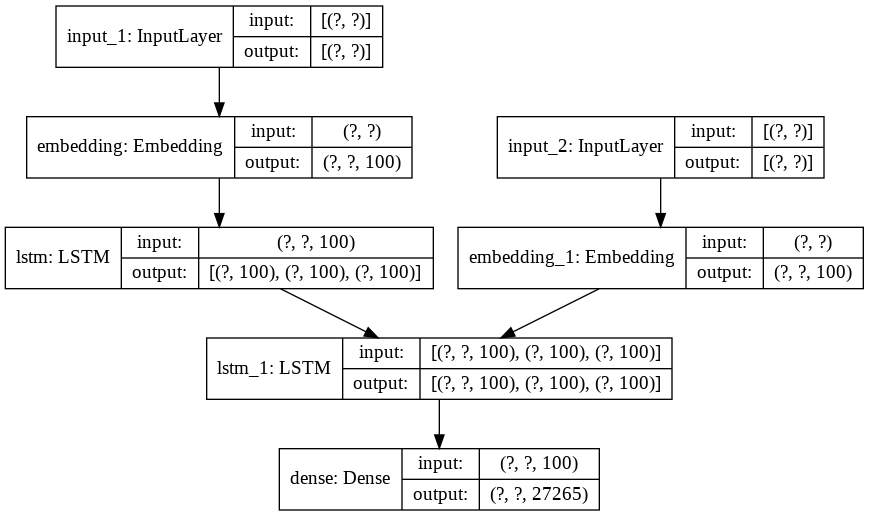

In [36]:
plot_model(model, show_shapes=True)

## Training

In [0]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 10

In [80]:
# in case of retraining, load the already trained model
model = load_model("english_to_spanish_nmt.h5")

In [81]:
history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size
                    )

Epoch 1/10
773/773 [==============================] - 439s 568ms/step - loss: 0.3320 - acc: 0.5406 - val_loss: 0.4158 - val_acc: 0.4903
Epoch 2/10
773/773 [==============================] - 438s 567ms/step - loss: 0.3130 - acc: 0.5584 - val_loss: 0.4072 - val_acc: 0.4971
Epoch 3/10
773/773 [==============================] - 438s 566ms/step - loss: 0.2960 - acc: 0.5752 - val_loss: 0.4003 - val_acc: 0.5050
Epoch 4/10
773/773 [==============================] - 438s 566ms/step - loss: 0.2805 - acc: 0.5904 - val_loss: 0.3954 - val_acc: 0.5101
Epoch 5/10
773/773 [==============================] - 437s 565ms/step - loss: 0.2664 - acc: 0.6048 - val_loss: 0.3900 - val_acc: 0.5166
Epoch 6/10
773/773 [==============================] - 437s 565ms/step - loss: 0.2535 - acc: 0.6192 - val_loss: 0.3858 - val_acc: 0.5211
Epoch 7/10
773/773 [==============================] - 438s 566ms/step - loss: 0.2417 - acc: 0.6323 - val_loss: 0.3837 - val_acc: 0.5239
Epoch 8/10
773/773 [============================

**The validation loss started increasing & validation accuracy started decreasing around 31-34 epochs.**

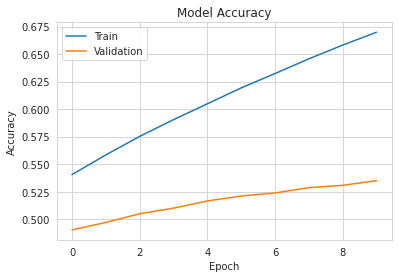

In [82]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

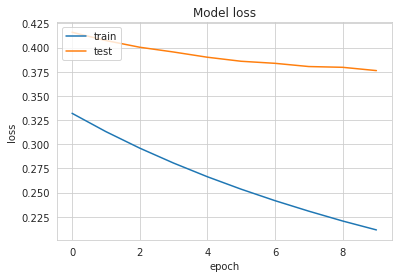

In [83]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save("english_to_spanish_nmt.h5")

In [90]:
model = load_model("english_to_spanish_nmt.h5")

## Inference

***Encoder Setup***

Encode the input sequence to get the encoder_states - `state_h & state_c`

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)

***Decoder setup***

Below tensors will hold the states of the previous time step. In case of the first sequence, assume - 
>1. decoder_state_input_c - state_c
>2. decoder_state_input_h - state_h


In [0]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

Get the embedding of decoder output sequences. For the first sequence, it will return the embedded vector for `START_` - [1., 0., 0., 0., 0.]. If the next predicted word is Juan, it will then return the embedded vector for `Juan` - [0., 0., 0., 1., 0.]

In [0]:
dec_emb2 = dec_emb_layer(decoder_inputs) 

To predict the next word in the sequence, set the initial states to the states from the previous time step


In [0]:
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)

Predict the next word in the sequence using the dense layer and choose the most probable word by selecting the word with most probability from the softmax probability distribution.

In [0]:
decoder_outputs2 = decoder_dense(decoder_outputs2) 

***Final Decoder Model***

Inputs -
>1. decoder_inputs - List of word
>2. decoder_states_inputs - previous timestep's hidden state & cell state

Outputs - 
>1. decoder_outputs2 - one-hot vector represeting the predicted word 
>2. decoder_states2 - current timestep's hidden state & cell state

In [0]:
decoder_states2 = [state_h2, state_c2]
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

## Decode Sequence

In [0]:
# https://github.com/numpy/numpy/issues/15201#issue-543733072

def categorical(p):
    return (p.cumsum(-1) >= np.random.uniform(size=p.shape[:-1])[..., None]).argmax(-1)

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sampling a token with max probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Sample from a categorical distribution
        # logits = output_tokens[0, -1, :]
        # sampled_token_index = categorical(np.reshape(logits, [-1, len(logits)]))[0]
         
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > max_length_tar):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

My attempt at using ***Beam Search Decoding*** using probabilites

In [0]:
def beam_search_decoder(predictions, top_k = 3):
    #start with an empty sequence with zero score
    output_sequences = [([], 0)]
    
    #looping through all the predictions
    for token_probs in predictions:
        new_sequences = []
        
        #append new tokens to old sequences and re-score
        for old_seq, old_score in output_sequences:
            for char_index in range(len(token_probs)):
                new_seq = old_seq + [char_index]
                #considering log-likelihood for scoring
                new_score = old_score + math.log(token_probs[char_index])
                new_sequences.append((new_seq, new_score))
                
        # sort all new sequences in the de-creasing order of their score
        output_sequences = sorted(new_sequences, key = lambda val: val[1], reverse = True)
        
        #select top-k based on score 
        # *Note- best sequence is with the highest score
        output_sequences = output_sequences[:top_k]
        
    return output_sequences

In [0]:
def decode_sequence_beam_search(input_seq):
    probabilites = []
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sampling a token with max probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        probabilites.append(output_tokens[0, -1, :])

        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > max_length_tar):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    # storing multiple results
    outputs = []
    beam_search_preds = beam_search_decoder(probabilites, top_k = 5)
    for prob_indexes, score in beam_search_preds:
        decoded_sentence = ''
        for index in prob_indexes:
            sampled_char = reverse_target_char_index[index]
            decoded_sentence += ' '+sampled_char
            if (sampled_char == '_END' or len(decoded_sentence) > max_length_tar):
                break
        outputs.append(decoded_sentence)

    return outputs

## Utility Function

In [0]:
import requests

url = "https://api.mymemory.translated.net/get"

def get_translation(seq):
    data = {}
    data["q"] = seq
    data["langpair"] = "es|en"
    response = requests.post(url, data=data)
    translated_text = response.json()["responseData"]["translatedText"]
    return translated_text

### Training Data

In [0]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [109]:
for _ in range(20):
    k+=1
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Sentence:', X_train[k:k+1].values[0])
    print('Actual Translation:', y_train[k:k+1].values[0][6:-4])
    print('Predicted Translation (Spanish):', decoded_sentence[:-4])
    # predicted spanish sequence back to english
    print('Predicted Translation (English):', get_translation(decoded_sentence[:-4]))
    print("="*60, end="\n\n")

Input Sentence: tom has hair down to his shoulders
Actual Translation:  tom tiene el pelo hasta los hombros 
Predicted Translation (Spanish):  tom tiene el pelo de cabeza 
Predicted Translation (English): tom has head hair

Input Sentence: i saw your light was on and knew you were still awake
Actual Translation:  vi que tenías la luz encendida y supe que todavía estabas despierto 
Predicted Translation (Spanish):  vi a tom y me había visto un poco de tráfico 
Predicted Translation (English): I saw tom and I had seen some traffic

Input Sentence: he came from one of the richest families in the united states
Actual Translation:  vino de una de las familias más ricas de américa 
Predicted Translation (Spanish):  él ha sido de nieve de los estados unidos a las
Predicted Translation (English): he&#39;s been snow from the united states at

Input Sentence: the park is in the center of the city
Actual Translation:  el parque se encuentra en el centro de la ciudad 
Predicted Translation (Spanis

In [110]:
for _ in range(20):
    k+=1
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentences = decode_sequence_beam_search(input_seq)
    print('Input Sentence:', X_train[k:k+1].values[0])
    print('Actual Translation:', y_train[k:k+1].values[0][6:-4])
    for idx, pred in enumerate(decoded_sentences):
        if pred[:-4] == y_train[k:k+1].values[0][6:-4]:
            print("-"*60)
            print(f"Correctly Predicted: {pred[:-4]}")
            print("-"*60)
        else:
            print(f'Predicted Translation {idx}: {pred[:-4]}')
    print("="*30, end="\n\n")

Input Sentence: you cant stop there
Actual Translation:  ahí no se puede parar 
Predicted Translation 0:  no puedes hacer nada 
Predicted Translation 1:  no puedes esperar nada 
Predicted Translation 2:  no puedes ir nada 
Predicted Translation 3:  no puedes parar nada 
Predicted Translation 4:  no puedes hacer algo 

Input Sentence: there is a girl reading under a tree
Actual Translation:  hay una niña leyendo bajo un árbol 
Predicted Translation 0:  hay una mujer muy grande para una 
Predicted Translation 1:  hay una chica muy grande para una 
Predicted Translation 2:  una una mujer muy grande para una 
Predicted Translation 3:  una una chica muy grande para una 
Predicted Translation 4:  hay una mujer de grande para una 

Input Sentence: im here every night
Actual Translation:  estoy aquí todas las noches 
Predicted Translation 0:  aquí estoy lloviendo 
Predicted Translation 1:  estoy estoy lloviendo 
Predicted Translation 2:  aquí me lloviendo 
Predicted Translation 3:  estoy me ll

### Testing Data

In [0]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [113]:
for _ in range(20):
    k+=1
    (input_seq, actual_output), _ = next(val_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Sentence:', X_test[k:k+1].values[0])
    print('Actual Translation:', y_test[k:k+1].values[0][6:-4])
    print('Predicted Translation (Spanish):', decoded_sentence[:-4])
    # predicted spanish sequence back to english
    print('Predicted Translation (English):', get_translation(decoded_sentence[:-4]))
    print("="*60, end="\n\n")

Input Sentence: if you are not firm with the children they will get out of hand
Actual Translation:  si no eres firme con los niños se te irán de las manos 
Predicted Translation (Spanish):  si no te vas a las manos y se fueron a los niños 
Predicted Translation (English): if you don&#39;t go to the hands and they went to the children

Input Sentence: tom is a redneck
Actual Translation:  tom es campesino 
Predicted Translation (Spanish):  tom es un error 
Predicted Translation (English): tom is a mistake

Input Sentence: tom had to admit that mary was right
Actual Translation:  tom tuvo que admitir que mary tenía razón 
Predicted Translation (Spanish):  tom tuvo que haber sido capaz de que mary estaba enf
Predicted Translation (English): Tom must have been able to see that Mary was up

Input Sentence: make a sentence with each of these words
Actual Translation:  hacé una oración con cada una de estas palabras 
Predicted Translation (Spanish):  tráeme el libro con las manos de arena 
P

In [114]:
k = 100
for _ in range(20):
    k+=1
    (input_seq, actual_output), _ = next(val_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Sentence:', X_test[k:k+1].values[0])
    print('Actual Translation:', y_test[k:k+1].values[0][6:-4])
    print('Predicted Translation (Spanish):', decoded_sentence[:-4])
    # predicted spanish sequence back to english
    print('Predicted Translation (English):', get_translation(decoded_sentence[:-4]))
    print("="*60, end="\n\n")

Input Sentence: im only doing this because i have nothing better to do
Actual Translation:  lo hago porque no tengo nada mejor que hacer 
Predicted Translation (Spanish):  no me aconsejó que me quedara 
Predicted Translation (English): did not advise me to stay

Input Sentence: i dont like stubborn people
Actual Translation:  no me gustan las personas tercas 
Predicted Translation (Spanish):  ¿cuáles son estos cosas 
Predicted Translation (English): What are these things

Input Sentence: when do you mean to start
Actual Translation:  ¿cuándo pretendes empezar 
Predicted Translation (Spanish):  tuvimos que aprender 
Predicted Translation (English): we had to learn

Input Sentence: it was very cold that winter
Actual Translation:  aquel invierno hizo mucho frío 
Predicted Translation (Spanish):  me encantan los gatos 
Predicted Translation (English): I love cats

Input Sentence: its no joke
Actual Translation:  no es una broma 
Predicted Translation (Spanish):  japón está en el extranjer

In [78]:
for _ in range(20):
    k+=1
    (input_seq, actual_output), _ = next(val_gen)
    decoded_sentences = decode_sequence_beam_search(input_seq)
    print('Input Sentence:', X_train[k:k+1].values[0])
    print('Actual Translation:', y_train[k:k+1].values[0][6:-4])
    for idx, pred in enumerate(decoded_sentences):
        if pred[:-4] == y_train[k:k+1].values[0][6:-4]:
            print("-"*60)
            print(f"Correctly Predicted: {pred[:-4]}")
            print("-"*60)
        else:
            print(f'Predicted Translation {idx}: {pred[:-4]}')
    print("="*30, end="\n\n")

Input Sentence: have you ever traveled by plane
Actual Translation:  ¿ha viajado alguna vez en avión 
Predicted Translation 0:  no me aconsejó que me quedara 
Predicted Translation 1:  no pude aconsejó que me quedara 
Predicted Translation 2:  no me aconsejó de me quedara 
Predicted Translation 3:  no me aconsejó que me fuera 
Predicted Translation 4:  no me aconsejó que me he 

Input Sentence: i was told i couldnt do that
Actual Translation:  me dijeron que no podía hacer eso 
Predicted Translation 0:  ¿cuáles son estos cosas 
Predicted Translation 1:  ¿qué son estos cosas 
Predicted Translation 2:  ¿de son estos cosas 
Predicted Translation 3:  ¿cuáles son son cosas 
Predicted Translation 4:  ¿cuáles son buenos cosas 

Input Sentence: walk more slowly
Actual Translation:  camina más despacio 
Predicted Translation 0:  tuvimos que aprender 
Predicted Translation 1:  tuvimos que ser 
Predicted Translation 2:  tuvimos que estar 
Predicted Translation 3:  tuvimos que haber 
Predicted Tra